<a href="https://colab.research.google.com/github/kevinwjin/pytorch-intro/blob/main/pytorchIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
A = [[6, 9, 2],
     [3, 3, 7],
     [1, 0, 3]]
A_tensor = torch.tensor(A)
A

In [ ]:
B = np.array([0, 1, 2, 3])
B_tensor = torch.from_numpy(B)
B

In [ ]:
C = torch.zeros(4, 4)
C

In [ ]:
D = torch.ones(3, 3, 2, dtype = torch.int)
D

In [ ]:
A_tensor_zeros = torch.zeros_like(A_tensor)
A_tensor_zeros

In [ ]:
# the dtype argument allows you to explicitly specify the datatype of the tensor
A_tensor_rand = torch.rand_like(A_tensor, dtype = torch.float)
A_tensor_rand

In [ ]:
A_tensor_rand.dtype
A_tensor_rand.shape
A_tensor_rand.device

In [ ]:
# True if a GPU (instead of CPU) is available to train on
torch.cuda.is_available()

In [ ]:
## Train image model on CIFAR10 dataset
# Define transform function; normalize images
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean
               (0.5, 0.5, 0.5))] # standard deviation
)

In [ ]:
training_data = CIFAR10(root = "cifar",
                        train = True, # training set, 50k images
                        download = True,
                        transform = transform)

test_data = CIFAR10(root = "cifar",
                    train = False, # test set, 10k images
                    download = True,
                    transform = transform)

In [ ]:
# Prepare to feed dataset into neural network
batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = batch_size,
                             shuffle = True)

In [27]:
for X, y in train_dataloader:
  print(f'Shape of X [N, C, H, W]: {X.shape}')
  print(f'Shape of y: {y.shape} {y.dtype}')
  break

# Each iteration through train_dataloader is a mini-batch of 
# four 32x32 images and their 4 corresponding labels.

Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


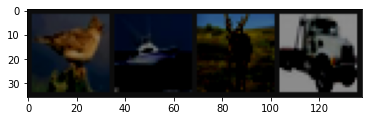

bird  ship  deer  truck


In [28]:
# Display a few images in the training set
def imshow(img):
  img = img / 2 + 0.05 # revert normalization for viewing
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

classes = training_data.classes
training_data.classes

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))